In [1]:
import numpy as np
from PIL import Image
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.color import rgb2gray
import os
from scipy.ndimage import center_of_mass
import shutil
import pandas as pd
from tqdm import tqdm

In [123]:

def calculate_extended_line(start_point, end_point, width, height):
    """
    주어진 두 점을 잇는 직선을 이미지 경계까지 확장합니다.

    Args:
        start_point (tuple): 시작점 (x1, y1).
        end_point (tuple): 끝점 (x2, y2).
        width (int): 이미지의 가로 크기.
        height (int): 이미지의 세로 크기.

    Returns:
        tuple: 직선의 시작점과 끝점 ((x1, y1), (x2, y2)).
    """
    x1, y1 = start_point
    x2, y2 = end_point

    # 기울기와 y절편 계산
    if x2 != x1:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    else:
        slope = None  # 수직선
        intercept = None

    # 경계와 교차점 계산
    points = []
    if slope is not None:
        # x=0 (왼쪽 경계)
        y = slope * 0 + intercept
        if 0 <= y < height:
            points.append((0, y))
        # x=width (오른쪽 경계)
        y = slope * width + intercept
        if 0 <= y < height:
            points.append((width, y))
        # y=0 (상단 경계)
        x = (0 - intercept) / slope if slope != 0 else np.inf
        if 0 <= x < width:
            points.append((x, 0))
        # y=height (하단 경계)
        x = (height - intercept) / slope if slope != 0 else np.inf
        if 0 <= x < width:
            points.append((x, height))
    else:
        # 수직선의 경우
        if 0 <= x1 < width:
            points.append((x1, 0))
            points.append((x1, height))

    # 유효한 교차점이 두 개 이상이면 반환
    if len(points) >= 2:
        return points[0], points[1]
    else:
        raise ValueError("No valid extended line points within image boundaries.")

# Load the binary image (replace 'your_binary_image.png' with your actual image file)
def calculate_line_points(slope, intercept, width, height):
    # 이미지 경계선(좌우, 상하)에 대해 교차점 계산
    points = []
    # x=0 (왼쪽 경계)
    y = slope * 0 + intercept
    if 0 <= y < height:
        points.append((0, y))
    # x=width (오른쪽 경계)
    y = slope * width + intercept
    if 0 <= y < height:
        points.append((width, y))
    # y=0 (상단 경계)
    x = (0 - intercept) / slope if slope != 0 else np.inf
    if 0 <= x < width:
        points.append((x, 0))
    # y=height (하단 경계)
    x = (height - intercept) / slope if slope != 0 else np.inf
    if 0 <= x < width:
        points.append((x, height))
    return points
def find_max_x_on_line(points, slope, intercept, tolerance=1):
    """
    주어진 점들 중 직선 방정식에 부합하며 x 값이 가장 큰 좌표를 찾습니다.
    
    Args:
        points (list of tuples): (x, y) 형식의 점들.
        slope (float): 직선의 기울기.
        intercept (float): 직선의 y-절편.
        tolerance (float): y = mx + b 오차 허용 범위.
    
    Returns:
        tuple: 직선 위에 위치하며 x 값이 가장 큰 점 (x, y).
    """
    max_x_point =0
    max_x_value = float('-inf')

    for x, y in points:
        # 직선 방정식 y = mx + b 확인
        expected_y = slope * x + intercept
        if abs(y - expected_y) <= tolerance:  # y 값이 직선 방정식에 부합
        
            if x > max_x_value:  # x 값이 현재 최대보다 크면 갱신
                max_x_value = x
                max_x_point = (x, y)

    return max_x_point

def calculate_angle_between_lines(start1, end1, start2, end2):
    """
    두 직선의 방향 벡터를 사용하여 사잇각을 계산합니다.
    
    Args:
        start1, end1: 첫 번째 직선의 시작점과 끝점 (x, y).
        start2, end2: 두 번째 직선의 시작점과 끝점 (x, y).
    
    Returns:
        angle: 두 직선 사이의 각도 (degrees).
    """
    # 첫 번째 직선의 방향 벡터
    vector1 = np.array([end1[0] - start1[0], end1[1] - start1[1]])
    # 두 번째 직선의 방향 벡터
    vector2 = np.array([end2[0] - start2[0], end2[1] - start2[1]])
    
    # 벡터 내적
    dot_product = np.dot(vector1, vector2)
    # 벡터 크기 계산
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    
    # 코사인 값 계산
    cos_theta = dot_product / (norm1 * norm2)
    # 각도 계산 (라디안 -> 도)
    angle = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))
    return angle


ddh_grade=[0,0,0]
total_df=pd.DataFrame(columns=['case','image','alpha','beta','DDH'])
total_count=0
for patient in range(1,21):
    df=pd.DataFrame(columns=['image','alpha','beta','DDH'])
    mask_list=glob('../../data/Graf_algorithm/dataset/'+str(patient)+'/mask/**')
    image_list=[mask.replace('/mask','/image')+'.png' for mask in mask_list]
    for i in tqdm(range(len(mask_list))):
        # base line and bony roof points
        mask_path = mask_list[i]+'/2.png'
        image_path=image_list[i]
        binary_image = np.array(Image.open(mask_path))
        raw_image = np.array(Image.open(image_path))
        rows, cols = np.where(binary_image > 0.5)
        points = np.column_stack((cols, rows))  
        pca = PCA(n_components=2)
        pca.fit(points) 
        center = pca.mean_  # 중심점 (평균 좌표)
        components = pca.components_  # 주성분 벡터
        slope = components[0][1] / components[0][0]  # 기울기
        intercept = center[1] - slope * center[0]  # y절편
        bony_roof_points = find_max_x_on_line(points, slope, intercept)
        # 5. 이미지 경계와 교차점 계산
        height, width = binary_image.shape
        line_points = calculate_line_points(slope, intercept, width, height)
        # 직선의 시작점과 끝점 설정
        if len(line_points) >= 2:
            base_line_start, base_line_end = line_points[:2]
        else:
            raise ValueError("No valid line points within image boundaries")

        #Center of labrum
        mask_path = mask_list[i]+'/1.png'
        binary_image = np.array(Image.open(mask_path))
        center_labrum_points = center_of_mass(binary_image)
        center_labrum_points=(int(center_labrum_points[1]),int(center_labrum_points[0]))

        #Bony rim point
        mask_path = mask_list[i]+'/3.png'
        binary_image = np.array(Image.open(mask_path))
        point=np.where(binary_image>0.5)
        y_max_index = np.argmax(point[0])  # Index of the maximum y-coordinate
        bony_rim_points = (point[1][y_max_index], point[0][y_max_index])  # (x, y) format

        #Liwer limb point
        mask_path = mask_list[i]+'/4.png'
        binary_image = np.array(Image.open(mask_path))
        point=np.where(binary_image>0.5)
        y_max_index = np.argmax(point[0])  # Index of the maximum y-coordinate
        lower_limb_points = (point[1][y_max_index], point[0][y_max_index])  # (x, y) format


        # line
        bony_roof_line_start, bony_roof_line_end = calculate_extended_line(bony_roof_points, lower_limb_points, width, height)
        carilage_roof_line_start, carilage_roof_line_end = calculate_extended_line(center_labrum_points, bony_rim_points, width, height)
        # base line과 bony roof line의 각도 계산
        base_bony_roof_between_lines = calculate_angle_between_lines(
            base_line_start, base_line_end,
            bony_roof_line_start, bony_roof_line_end
        )
        # base line과 bony roof line의 각도 계산
        base_carilage_roof_between_lines = calculate_angle_between_lines(
            base_line_start, base_line_end,
            carilage_roof_line_start, carilage_roof_line_end
        )
        beta_angle=180-base_carilage_roof_between_lines
        alpha_angle=base_bony_roof_between_lines
        if beta_angle>90:
            beta_angle=180-beta_angle
        # print(f"Base line과 Carilage roof line 사이의 각도: {180-base_carilage_roof_between_lines:.2f}°")
        # print(f"Base line과 Bony roof line 사이의 각도: {base_bony_roof_between_lines:.2f}°")
        if alpha_angle<43:
            ddh_grade[2]+=1
            DDH_result=2
        elif alpha_angle>=43 and alpha_angle<59:
            if beta_angle<=77:
                ddh_grade[1]+=1
                DDH_result=1
            else:
                ddh_grade[2]+=1
                DDH_result=2
        else:
            ddh_grade[0]+=1
            DDH_result=0
        df.loc[i]=[os.path.basename(image_path), alpha_angle,beta_angle,DDH_result]
        total_df.loc[total_count]=[os.path.basename(os.path.dirname(os.path.dirname(image_path))),os.path.basename(image_path), alpha_angle,beta_angle,DDH_result]
        total_count+=1
    df.to_csv('../../data/Graf_algorithm/dataset/'+str(patient)+'/result.csv',index=False)
total_df.to_csv('../../data/Graf_algorithm/dataset/result.csv',index=False)
print(f'ddh_grade0:{ddh_grade[0]}\nddh_grade1:{ddh_grade[1]}\nddh_grade2:{ddh_grade[2]}')

# # 6. 시각화
# plt.figure(figsize=(8, 8))
# plt.imshow(raw_image, cmap='gray', origin='upper', extent=(0, raw_image.shape[1], raw_image.shape[0], 0))

# plt.plot([base_line_start[0], base_line_end[0]], [base_line_start[1], base_line_end[1]], color='yellow', linestyle='--', linewidth=2, label="base line")
# plt.plot([bony_roof_line_start[0], bony_roof_line_end[0]], [bony_roof_line_start[1],bony_roof_line_end[1]], color='red', linestyle='--', linewidth=2, label="bony roof line")
# plt.plot([carilage_roof_line_start[0], carilage_roof_line_end[0]], [carilage_roof_line_start[1],carilage_roof_line_end[1]], color='skyblue', linestyle='--', linewidth=2, label="carilage roof line")

# plt.scatter(bony_roof_points[0], bony_roof_points[1],facecolors='none', edgecolors='red', linewidths=2,label="bony roof point", s=50)
# plt.scatter(center_labrum_points[0], center_labrum_points[1], facecolors='none', edgecolors='skyblue', linewidths=2, label="Center of labrum", s=50)
# plt.scatter(bony_rim_points[0], bony_rim_points[1], facecolors='none', edgecolors='yellow', linewidths=2, label="Bony rim point", s=50)
# plt.scatter(lower_limb_points[0], lower_limb_points[1], facecolors='none', edgecolors='lime', linewidths=2, label="Lower limb point", s=50)
# plt.title("Graf Algorithm")
# plt.legend()
# plt.axis('equal')
# plt.tight_layout()  
# plt.show()


100%|██████████| 468/468 [00:33<00:00, 13.96it/s]


ddh_grade0:2667
ddh_grade1:1369
ddh_grade2:375


In [ ]:
df=pd.read_csv('../../data/Graf_algorithm/dataset/result.csv')
filtered_data = df[df['DDH'] == 0]
# 원하는 데이터셋 크기 설정
train_size = 2024
test_size = 354
val_size = 289

# 데이터셋 크기 확인
total_size = train_size + test_size + val_size

if len(filtered_data) < total_size:
    raise ValueError("Filtered data is smaller than the required split sizes.")

# 데이터 섞기 (선택 사항)
filtered_data = filtered_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 데이터 분할
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:train_size + test_size]
val_data = filtered_data.iloc[train_size + test_size:train_size + test_size + val_size]

filtered_data = df[df['DDH'] == 1]
# 원하는 데이터셋 크기 설정
train_size = 1037
test_size = 183
val_size = 149

# 데이터셋 크기 확인
total_size = train_size + test_size + val_size

if len(filtered_data) < total_size:
    raise ValueError("Filtered data is smaller than the required split sizes.")

# 데이터 섞기 (선택 사항)
filtered_data = filtered_data.sample(frac=1, random_state=42).reset_index(drop=True)


filtered_data = df[df['DDH'] == 2]
# 원하는 데이터셋 크기 설정
train_size = 285
test_size = 49
val_size = 41

# 데이터셋 크기 확인
total_size = train_size + test_size + val_size

if len(filtered_data) < total_size:
    raise ValueError("Filtered data is smaller than the required split sizes.")

# 데이터 섞기 (선택 사항)
filtered_data = filtered_data.sample(frac=1, random_state=42).reset_index(drop=True)


# 결과 확인
print("Train Data:")
print(train_data)
print("\nTest Data:")
print(test_data)
print("\nValidation Data:")
print(val_data)

Train Data:
      case      image      alpha       beta  DDH
0        4  01651.png  62.743517  57.974140    0
1       16  03102.png  67.817620  66.566320    0
2       15  00441.png  66.963323  69.046663    0
3       20  00348.png  65.388607  68.247124    0
4       11  00363.png  73.858204  56.001456    0
...    ...        ...        ...        ...  ...
2019     6  00406.png  59.883173  66.952409    0
2020     2  00439.png  59.784395  82.136723    0
2021     7  00942.png  71.784308  57.064250    0
2022    16  03638.png  64.330470  73.791660    0
2023    18  03073.png  66.012894  63.464571    0

[2024 rows x 5 columns]

Test Data:
      case      image       alpha       beta  DDH
2024    18  00207.png   61.883322  62.968629    0
2025    15  00291.png   73.306487  74.284905    0
2026    11  00201.png   74.343719  49.317455    0
2027    15  00750.png  130.740703  83.589317    0
2028    20  00377.png   66.664540  69.205568    0
...    ...        ...         ...        ...  ...
2308     1  0

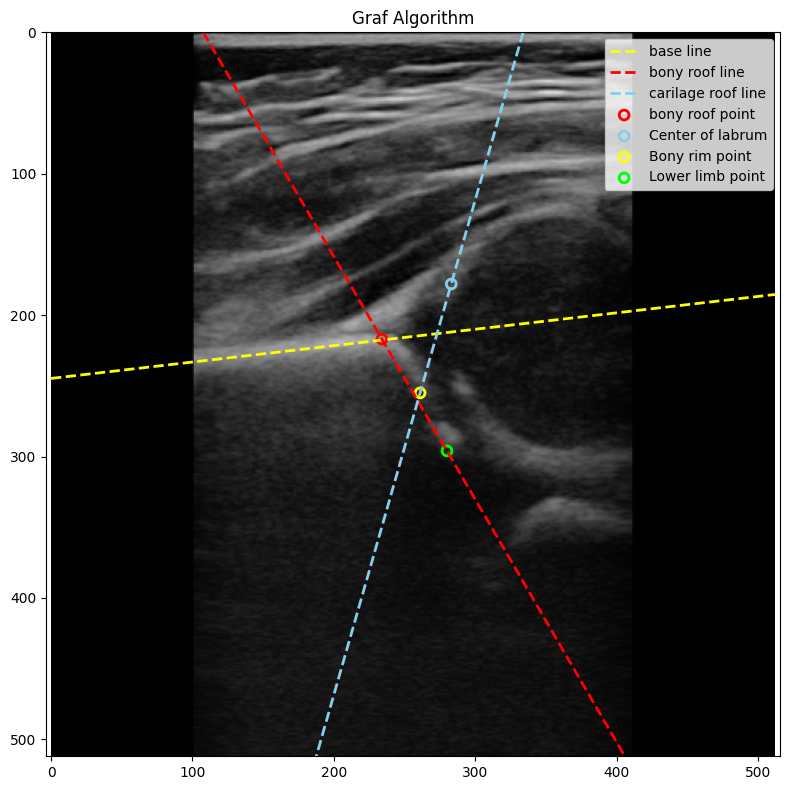

In [107]:
# 6. 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raw_image, cmap='gray', origin='upper', extent=(0, raw_image.shape[1], raw_image.shape[0], 0))

plt.plot([base_line_start[0], base_line_end[0]], [base_line_start[1], base_line_end[1]], color='yellow', linestyle='--', linewidth=2, label="base line")
plt.plot([bony_roof_line_start[0], bony_roof_line_end[0]], [bony_roof_line_start[1],bony_roof_line_end[1]], color='red', linestyle='--', linewidth=2, label="bony roof line")
plt.plot([carilage_roof_line_start[0], carilage_roof_line_end[0]], [carilage_roof_line_start[1],carilage_roof_line_end[1]], color='skyblue', linestyle='--', linewidth=2, label="carilage roof line")

plt.scatter(bony_roof_points[0], bony_roof_points[1],facecolors='none', edgecolors='red', linewidths=2,label="bony roof point", s=50)
plt.scatter(center_labrum_points[0], center_labrum_points[1], facecolors='none', edgecolors='skyblue', linewidths=2, label="Center of labrum", s=50)
plt.scatter(bony_rim_points[0], bony_rim_points[1], facecolors='none', edgecolors='yellow', linewidths=2, label="Bony rim point", s=50)
plt.scatter(lower_limb_points[0], lower_limb_points[1], facecolors='none', edgecolors='lime', linewidths=2, label="Lower limb point", s=50)
plt.title("Graf Algorithm")
plt.legend()
plt.axis('equal')
plt.tight_layout()  
plt.show()